In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import random
import numpy as np
import scipy.stats
import seaborn as sns

In [2]:
def initialize(N, cls, p=0, k=0):
    if cls == 'random':
        G =  nx.erdos_renyi_graph(N, p)
    elif cls == 'watts':
        G = nx.connected_watts_strogatz_graph(N, k=k, p=p)
    elif cls == 'ring':
        G = nx.watts_strogatz_graph(N, k=k, p=0)
    elif cls == 'barabasi':
        G = nx.powerlaw_cluster_graph(N, m=k, p=p)
    else:
        G = nx.Graph()
        for i in range(N):
            G.add_node(i)
        for i in range(N):
            for j in range(N):
                if i != j:
                    G.add_edge(i, j)
    for node in G.nodes():
        G.node[node]['power'] = 5
    return G




def generate_power(G, a):
    for i, node in enumerate(G.nodes()):
        if G.node[node]['power'] == 0:
            continue
        G.node[node]['power'] += a[i]
        if G.node[node]['power'] > 20:
            G.node[node]['power'] = 20
        if G.node[node]['power'] < 0:
            G.node[node]['power'] = 0
        #G.node[node]['power'] += random.uniform(0, a)
    return G


def use_power(G):
    for node in G.nodes():
        if G.node[node]['power'] == 0:
            continue
        G.node[node]['power'] -= 1
    return G


def send_power(G):
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        neighbors = random.sample(neighbors, len(neighbors))
        for neighbor in neighbors:
            if G.node[neighbor]['power'] >= 5:
                neighbors.remove(neighbor)
        for neighbor in neighbors:
            while G.node[neighbor]['power'] < 5 and G.node[neighbor]['power'] > 0  and G.node[node]['power'] > 5:
                G.node[neighbor]['power'] += 1
                G.node[node]['power'] -= 1
    return G


def get_global_status(G):
    total_power = sum([G.node[node]['power'] for node in G.nodes()])
    return total_power / len(G.nodes())

def get_local_status(G):
    return np.array([G.node[node]['power'] for node in G.nodes()])
    

In [58]:
N = 50
max_it = 1000
a = 2
p = 0.5
k = 4

graphs = [initialize(N, None), initialize(N, 'random', p=p),
          initialize(N, 'watts', k=k, p=p),initialize(N, 'barabasi', k=k)]
labels = ['mean field', 'random', 'watts', 'barabasi']
local_status = np.zeros((4, max_it, N))
#random_walker = np.zeros((max_it))

a_arr= np.random.randint(0,a+1, size=(max_it,N))
for t in range(max_it):
    for i, G in enumerate(graphs):
        G = use_power(G)
        G = generate_power(G, a_arr[t,:])
        G = send_power(G)
        local_status[i, t,:] = get_local_status(G)
        
#if t == 0:
#	continue
#   random_walker[t] = random_walker[t-1] + random.gauss(0,2)/20

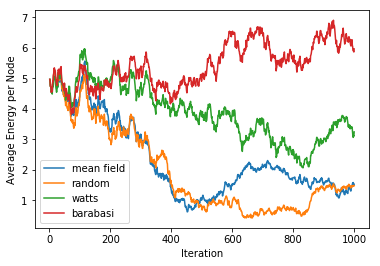

In [59]:


#Average energy in the system
for i  in range(len(graphs)):
    plt.plot(range(1, max_it+1), np.mean(local_status[i,:,:], axis=1), label=labels[i])
plt.xlabel('Iteration')
plt.ylabel('Average Energy per Node')
plt.legend(loc=0)
plt.show()

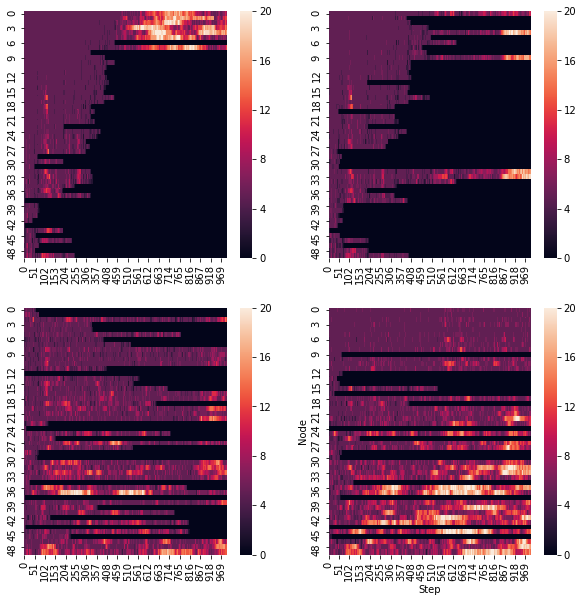

In [60]:

fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        sns.heatmap(local_status[i*2+j,:,:].T, 
                    ax=axes[i,j])
plt.ylabel("Node")
plt.xlabel("Step")
plt.show()

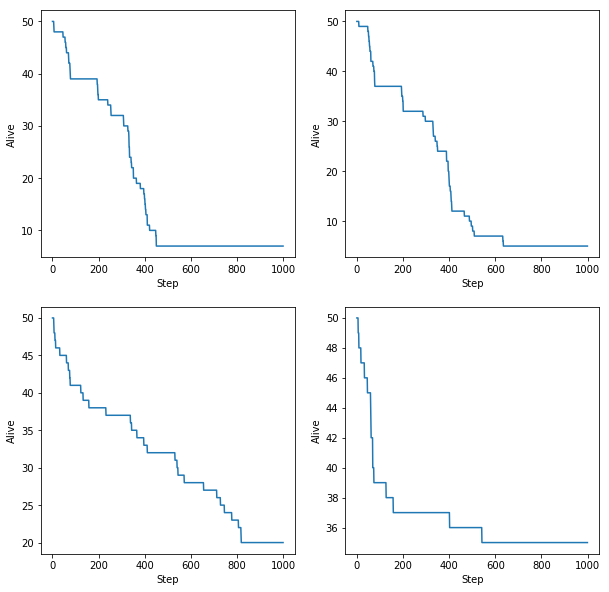

In [61]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        alive = [len(np.nonzero(local_status[i*2+j,t, :])[0]) for t in  range(max_it)]
        axes[i,j].plot(range(max_it), alive)
        axes[i,j].set_ylabel("Alive")
        axes[i,j].set_xlabel("Step")
plt.show()

